# 0. Install Dependencies and Bring in Data

In [1]:
#!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
!pip install datasets

In [4]:
import datasets 
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
data = dataset['train'].to_pandas()
data.describe()

C:\Users\snara\.conda\envs\tf-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration ucberkeley-dlab--measuring-hate-speech-b2914663eaad033d
Reusing dataset parquet (C:\Users\snara\.cache\huggingface\datasets\ucberkeley-dlab___parquet\ucberkeley-dlab--measuring-hate-speech-b2914663eaad033d\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.80it/s]


,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [5]:
df=data.iloc[:50000, 3:13]
df['hatespeech'] = df['hatespeech'].replace(1,3)
df['hatespeech'] = df['hatespeech'].replace(2,4)
#df.loc[ df['hatespeech'] == '1', 'hatespeech'] = '3'
f = lambda x: 1 if x>=3.0 else 0
df=df.applymap(f)

In [6]:
new_df=pd.DataFrame()
new_df['text'] = data['text'][:50000]
new_df['label'] = df.iloc[:,:].values.tolist()

In [7]:
new_df.shape

(50000, 2)

# 1. Preprocess

In [8]:
from tensorflow.keras.layers import TextVectorization

In [9]:
X = new_df['text']
y = new_df['label'].values

In [10]:
MAX_FEATURES = 200000 # number of words in the vocab

In [11]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [12]:
vectorizer.adapt(X.values)

In [13]:
vectorized_text = vectorizer(X.values)

In [14]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, np.array([np.array(val) for val in new_df['label']])))
dataset = dataset.cache()
dataset = dataset.shuffle(16)
dataset = dataset.batch(200)
dataset = dataset.prefetch(8) # helps bottlenecks

In [15]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [17]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(10, activation='sigmoid'))

In [18]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                        

In [20]:
history = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100
175/175 [==============================] - 38s 183ms/step - loss: 0.5364 - val_loss: 0.4685
Epoch 2/100
175/175 [==============================] - 31s 178ms/step - loss: 0.4343 - val_loss: 0.4576
Epoch 3/100
175/175 [==============================] - 32s 181ms/step - loss: 0.3925 - val_loss: 0.4697
Epoch 4/100
175/175 [==============================] - 32s 185ms/step - loss: 0.3664 - val_loss: 0.5032
Epoch 5/100
175/175 [==============================] - 30s 174ms/step - loss: 0.3500 - val_loss: 0.4796
Epoch 6/100
175/175 [==============================] - 30s 174ms/step - loss: 0.3353 - val_loss: 0.4944
Epoch 7/100
175/175 [==============================] - 33s 187ms/step - loss: 0.3195 - val_loss: 0.5417
Epoch 8/100
175/175 [==============================] - 31s 180ms/step - loss: 0.3081 - val_loss: 0.5621
Epoch 9/100
175/175 [==============================] - 32s 183ms/step - loss: 0.3021 - val_loss: 0.5423
Epoch 10/100
175/175 [==============================] - 32s 181m

175/175 [==============================] - 35s 199ms/step - loss: 0.1289 - val_loss: 3.3243
Epoch 80/100
175/175 [==============================] - 36s 205ms/step - loss: 0.1304 - val_loss: 3.0736
Epoch 81/100
175/175 [==============================] - 34s 197ms/step - loss: 0.1336 - val_loss: 3.0170
Epoch 82/100
175/175 [==============================] - 33s 186ms/step - loss: 0.1345 - val_loss: 2.8670
Epoch 83/100
175/175 [==============================] - 34s 194ms/step - loss: 0.1333 - val_loss: 3.1083
Epoch 84/100
175/175 [==============================] - 34s 192ms/step - loss: 0.1284 - val_loss: 3.4620
Epoch 85/100
175/175 [==============================] - 35s 198ms/step - loss: 0.1253 - val_loss: 3.5913
Epoch 86/100
175/175 [==============================] - 36s 208ms/step - loss: 0.1242 - val_loss: 3.7337
Epoch 87/100
175/175 [==============================] - 34s 196ms/step - loss: 0.1228 - val_loss: 3.9767
Epoch 88/100
175/175 [==============================] - 34s 193ms/st

In [21]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

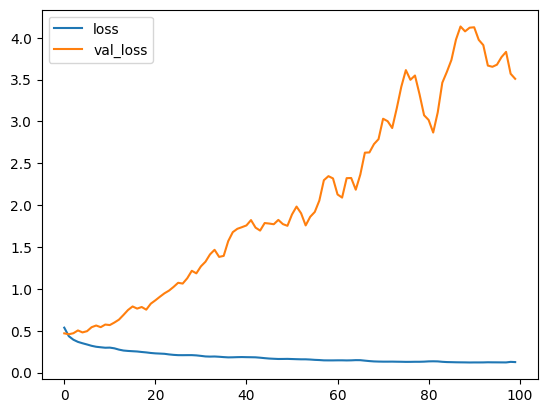

In [22]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [23]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   6, 3258,  205, ...,    0,    0,    0], dtype=int64)>

In [24]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 799ms/step


In [25]:
(res > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [27]:
(model.predict(batch_X) > 0.5).astype(int)

7/7 [==============================] - 1s 77ms/step


array([[1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
res.shape

(1, 10)

# 4. Evaluate Model

In [29]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

7/7 [==============================] - 1s 95ms/step


In [32]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7311154007911682, Recall:0.6935917139053345, Accuracy:0.3199999928474426
